# Inference

In [1]:
import scanpy as sc

In [2]:
czi_reference = sc.read_h5ad("../data/datasets/czi_covid_pbmc_5pct.h5ad")
id2type = dict(enumerate(czi_reference.obs["cell_type"].astype("category").cat.categories))
# czi_reference.obs.cell_type

In [ ]:
adata_read = sc.read_h5ad("../data/inference/influenzaPBMC.h5ad")
adata = sc.pp.subsample(adata_read, n_obs = 30000, copy=True, random_state=42)
adata.obs.rename(columns={"gene_name": "feature_name"}, inplace=True)

In [ ]:
from scgpt.preprocess import Preprocessor

preprocessor = Preprocessor(
    use_key="X",
    normalize_total=1e4,
    result_normed_key="X_normed",
    log1p=False,  # or True, depending on original training
    binning=51,
    result_binned_key="X_binned"
)
preprocessor(adata)

In [ ]:
from scgpt.model import TransformerModel
from scgpt.tokenizer.gene_tokenizer import GeneVocab
import torch
import json

# Load the model config
with open("../models/scgpt_human/args.json") as f:
    args = json.load(f)

# Load vocab
vocab = GeneVocab.from_file("../models/scgpt_human/vocab.json")
vocab.set_default_index(vocab["<pad>"])

# Number of cell types in NEW dataset (not original training set)
num_cell_types = 97  # update this

# Initialize model
model = TransformerModel(
    ntoken=len(vocab),
    d_model=args["embsize"],
    nhead=args["nheads"],
    d_hid=args["d_hid"],
    nlayers=args["nlayers"],
    nlayers_cls=args.get("n_layers_cls", 3),
    n_cls=num_cell_types,
    vocab=vocab,
    dropout=args.get("dropout", 0.2),
    pad_token="<pad>",
    pad_value=-2,
    input_emb_style="continuous",
    n_input_bins=args.get("n_input_bins", 51),
    cell_emb_style="cls",
    use_fast_transformer=args.get("fast_transformer", False),
    fast_transformer_backend=args.get("fast_transformer_backend", "flash"),
    pre_norm=args.get("pre_norm", False),
)

In [ ]:
state_dict = torch.load("save/finetuning_czi_5pct_2pct/model.pt", map_location="cpu")

if all(k.startswith("module.") for k in state_dict.keys()):
    state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}

In [ ]:
model.load_state_dict(state_dict)
model.eval()

In [ ]:
from scgpt.tokenizer import tokenize_and_pad_batch
import numpy as np
gene_ids = np.array([vocab[gene] for gene in adata.var_names], dtype=int)

counts = adata.layers["X_binned"]  # must match input_layer_key from training

tokenized = tokenize_and_pad_batch(
    counts,
    gene_ids,
    max_len=3001,
    vocab=vocab,
    pad_token="<pad>",
    pad_value=-2,
    append_cls=True,
    include_zero_gene=False
)

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
import pandas as pd

# Define inference dataset
class InferenceDataset(Dataset):
    def __init__(self, tokenized):
        self.data = tokenized

    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.data.items()}

    def __len__(self):
        return self.data["genes"].shape[0]

# Create dataset and loader
dataset = InferenceDataset(tokenized)
loader = DataLoader(
    dataset, 
    batch_size=12,     # You can experiment with 512, 1024, or 2048 on A30s
    num_workers=8,      # Reduce for GPU-bound tasks
    pin_memory=True,    # Enable for GPU
    shuffle=False
)

# Move model to GPU and set eval mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Run inference and collect predictions
all_preds = []
with torch.no_grad():
    for batch in loader:
        input_ids = batch["genes"].to(device, non_blocking=True)
        values = batch["values"].to(device, non_blocking=True)
        src_key_padding_mask = input_ids.eq(vocab["<pad>"])

        out = model(input_ids, values, src_key_padding_mask=src_key_padding_mask, CLS=True)
        preds = out["cls_output"].argmax(1)
        all_preds.extend(preds.cpu().numpy())  # Move to CPU for final aggregation

# Save predictions to adata.obs
adata.obs["predictions"] = pd.Categorical(all_preds)

In [ ]:
# Ensure predictions are integers (in case they're categorical)
pred_ids = adata.obs["predictions"].astype(int)

# Map to cell type names using id2type
adata.obs["predicted_celltype"] = pred_ids.map(id2type)

In [ ]:
adata.obs

In [ ]:
import pandas as pd

# Ensure predictions and original cell types are in the same DataFrame
comparison_df = adata.obs[["celltype", "predicted_celltype"]]

# Display the comparison
# print(comparison_df)

# Optionally, group by cell types to see counts for each prediction
grouped_counts = adata.obs.groupby(["celltype", "predicted_celltype"]).size().reset_index(name="count")
sorted_counts = grouped_counts.sort_values(by="count", ascending=False)

print(sorted_counts)

In [ ]:
# Group by 'celltype' and 'predicted_celltype' and count occurrences
grouped_counts = adata.obs.groupby(["celltype", "predicted_celltype"]).size().reset_index(name="count")

# Calculate percentages for each 'celltype'
grouped_counts["percentage"] = grouped_counts.groupby("celltype")["count"].transform(lambda x: (x / x.sum()) * 100)

# Filter out rows where percentage is 0
filtered_counts = grouped_counts[grouped_counts["percentage"] > 0]

# Sort by 'celltype' and 'percentage' in descending order
sorted_counts = filtered_counts.sort_values(by=["celltype", "percentage"], ascending=[True, False])

# Print the results
for celltype, group in sorted_counts.groupby("celltype"):
    print(f"Cell Type: {celltype}")
    print(group[["predicted_celltype", "count", "percentage"]])
    print("-" * 50)

In [ ]:
adata.write_h5ad("../data/inference/mukundPBMCPredictions.h5ad")

## Visualization

In [ ]:
import scanpy as sc


In [7]:
sc.pp.neighbors(adata_preds)
sc.tl.umap(adata_preds)

/home/s5srinivasan/py39env/lib64/python3.9/site-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 14063 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


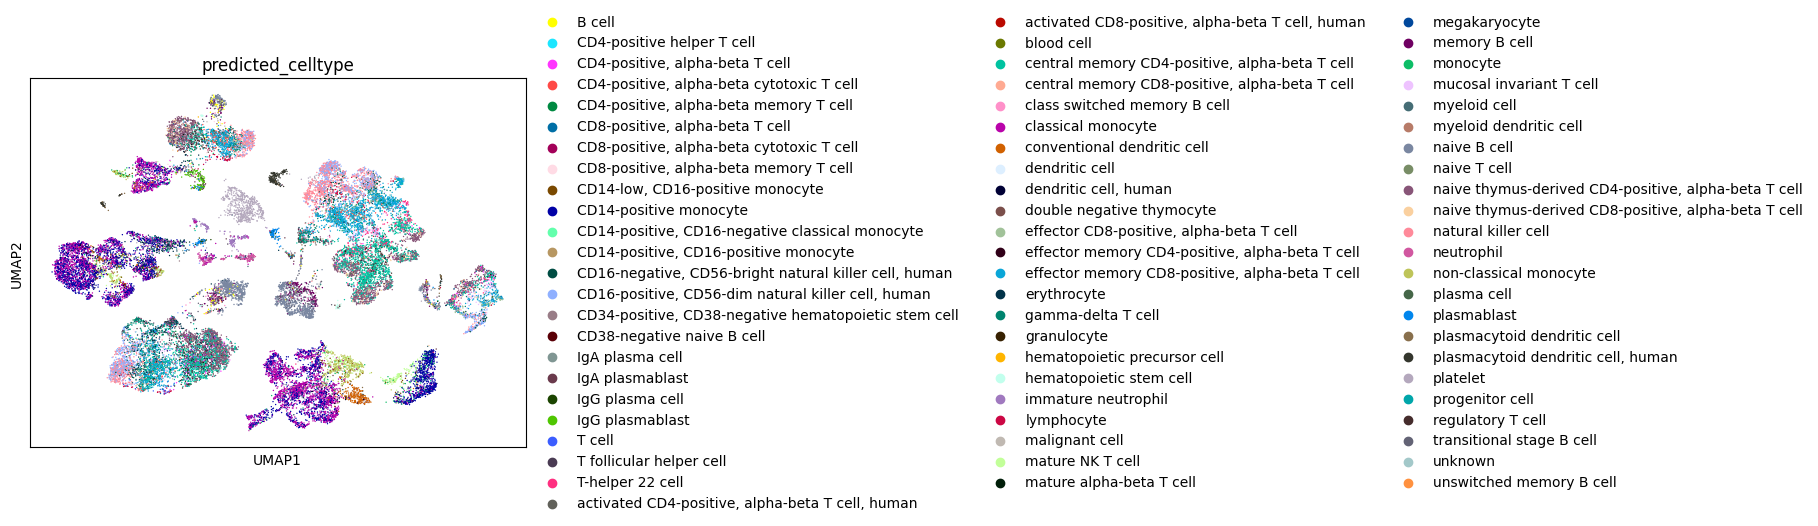

In [14]:
sc.pl.umap(adata_preds, color="predicted_celltype")

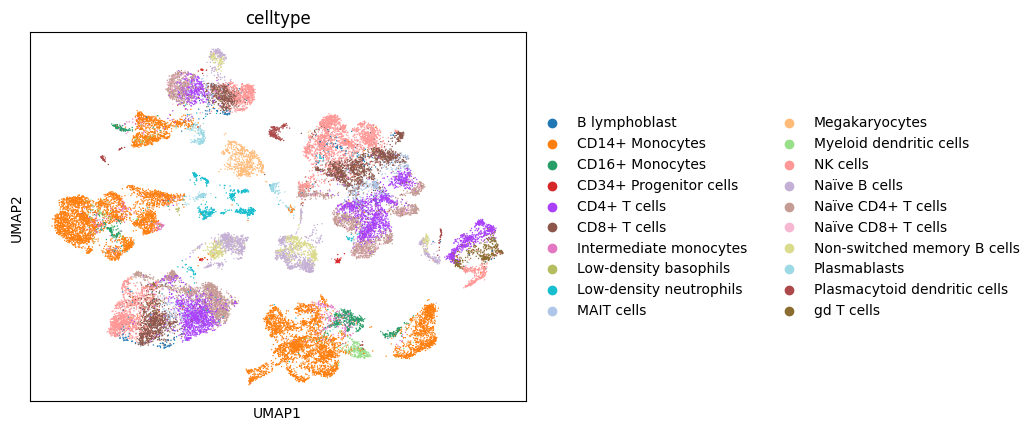

In [15]:
sc.pl.umap(adata_preds, color="celltype")

In [13]:
adata_preds.obs

,orig.ident,nCount_RNA,nFeature_RNA,Infection_status,Severity,log10GenesPerUMI,percent.mt,percent.Heme,Study,seurat_clusters,new.annot2,celltype,celltype_id,batch_id,predictions,predicted_celltype
CGCGTGATCCTACCGT-19_2,Normal 1,8518.0,2456,Healthy,Healthy,0.860853,4.168009,0.000000,Lee,22,1,CD4+ T cells,4,1,30,T-helper 22 cell
10_GAAGTAAAGGATATAC-1_3,cov_scrna_12,26513.0,3509,Covid,Non-severe,0.804305,8.161374,0.010692,Bali,38,15,Plasmablasts,17,0,87,plasmablast
GAGCCAATAAGGGCTGGTAAGCCTTCT_17_5,BN-10,4210.0,1532,Covid,Severe,0.881907,19.105601,0.088554,SS_C2,11,6,Non-switched memory B cells,16,3,94,transitional stage B cell
GAGTATTAGAAGCTACTTGCTCCTTGA_5_5,BN-16,2763.0,1217,Covid,Severe,0.894417,17.910448,0.099502,SS_C2,4,4,CD14+ Monocytes,1,3,3,CD14-positive monocyte
AGCCATCACATTAGGCATCAAGTTTCC_18_5,BN-31,2501.0,964,Healthy,Healthy,0.882119,24.043511,0.112528,SS_C2,2,2,CD8+ T cells,5,3,36,"central memory CD4-positive, alpha-beta T cell"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4_TGGAGGACATGCGTGC-1_4,C19-CB-0012,10049.0,2054,Covid,Severe,0.828727,3.929641,0.056138,SS_C1,25,4,CD14+ Monocytes,1,2,3,CD14-positive monocyte
9_CAACCAAAGGATGTTA-1_3,cov_scrna_11,10526.0,2691,Covid,Severe,0.855204,2.448535,0.000000,Bali,12,4,CD14+ Monocytes,1,0,3,CD14-positive monocyte
CAAAGGCACCACAAAGGCAAAGAGGCC_17_5,BN-29,3016.0,1100,Healthy,Healthy,0.879003,22.341733,0.061463,SS_C2,32,12,Naïve CD8+ T cells,15,3,36,"central memory CD4-positive, alpha-beta T cell"
AGGAGATTACACCCAAAGGAACGACAA_17_5,BN-26,2987.0,1276,Healthy,Healthy,0.893924,23.487872,0.061406,SS_C2,44,0,NK cells,12,3,7,"CD16-positive, CD56-dim natural killer cell, h..."
